In [332]:
# import os
# import tensorflow as tf
# print(tf.device('/gpu:0'))
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [333]:
#导包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import time
# from keras import metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, average_precision_score, f1_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# from numba import jit
# @jit(nopython==True)

In [334]:
#导入方法
from SimilitudItems import *

In [335]:
# start = time.time()

In [336]:
#初始化一些参数
K1 = 3
K2 = -10
beta = 0.15
alpha = 0.85 #两个K和alpha在处理打分矩阵时候用到
Ucluster_number = 3 #输出聚类结果的前三个
iter_num = 50 #y的行数
Proportion = 1024 #训练集&测试集数据比例

In [337]:
#初始化参数
mycase = 1   # 读取哪个数据集
neibor_num = 40  # 邻居数
inter_value = 40 # 动力学演化中间值

In [338]:
#读取数据
# 读训练集
if mycase == 1:
    u = pd.read_csv("features.csv")
    print(type(u))
    # 分成训练和测试两块
    uf = u.sample(Proportion)
    u1 = u.drop(uf.index)
    u1.reset_index(drop=True, inplace=True)
    uf.reset_index(drop=True, inplace=True)
    print(len(u1))
    # print(u1,u2)
    # print(u)
    # for i in range(len(u)):
    #     if (u.loc[i,"score"]<100.0):
    #         u.loc[i,"score"] = 10.0
    #     elif (100.0<u.loc[i,"score"]<1000.0):
    #         u.loc[i,"score"] = 20.0
    #     elif (1000.0<u.loc[i, "score"] < 10000.0):
    #         u.loc[i, "score"] = 30.0
    #     elif (10000.0<u.loc[i, "score"] < 100000.0):
    #         u.loc[i, "score"] = 40.0
    # print(u)
    # u1 = u.iloc[:6400,:]
    # uf = u.iloc[6400:,:]
    # print(uf)
    # u1 = pd.read_csv("u1base.csv")
elif mycase == 2:
    u1 = pd.read_csv("u2base.csv")
elif mycase == 3:
    u1 = pd.read_csv("u3base.csv")
elif mycase == 4:
    u1 = pd.read_csv("u4base.csv")
elif mycase == 5:
    u1 = pd.read_csv("u5base.csv")

<class 'pandas.core.frame.DataFrame'>
5413


In [339]:
#查看大小
# print(u1.shape[0])
m = u1.shape[0]  # 训练集评分行为数量
print(u1)

      user_id  item_id    score  time
0           1        6    1.996   NaN
1           1       10   11.961   NaN
2           1       15  186.073   NaN
3           1       21  192.628   NaN
4           1       26  405.940   NaN
...       ...      ...      ...   ...
5408      212       42   52.818   NaN
5409      212       59   37.387   NaN
5410      212       69   42.005   NaN
5411      212       70   42.586   NaN
5412      212       86   13.859   NaN

[5413 rows x 4 columns]


In [340]:
#把csv表转化为矩阵  横坐标用户id，纵坐标电源id，值为评分
# 建立评分矩阵
number_user = int(max(u1["user_id"])) # 获取用户数量，为943
number_movies = int(max(u1["item_id"])) # 获取电影数量，为1682
N = number_user + number_movies # N = 用户数量 + 电影数量 = 2625
# print(type(number_movies),number_user,N)
score_matrix = np.zeros([number_user, number_movies])

In [341]:
#对矩阵元素进行赋值
for i in range(0, m):
    score_matrix[int(u1["user_id"][i]-1)][int(u1["item_id"][i]-1)] = u1["score"][i] # 填评分矩阵
    # 由于下标从0开始，所以用户id和电影id需要-1

In [342]:
#把评分矩阵放入另一个矩阵
# score_matrix = np.pad(score_matrix, ((0,1682) , (943,0)), mode = 'constant', constant_values=(0, 0))
adj_matrix = np.zeros((N, N))
adj_matrix[0 : number_user, number_user : N] = score_matrix  # 异质网络右上角：评分矩阵
adj_matrix += adj_matrix.T  # 异质网络左下角：评分矩阵转置
print(adj_matrix)

[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    1.   ]
 [0.    0.    0.    ... 3.742 0.    4.537]
 ...
 [0.    0.    3.742 ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    1.    4.537 ... 0.    0.    0.   ]]


In [343]:
#再建一个矩阵，第一行赋予任意值
y = np.zeros((iter_num, N)) # y规模为 iter * 2625
y[0, :] = np.random.rand(N) * math.pi/2 # y第一行所有值都处于[0, pi/2]之间

In [344]:
#利用上面得到的打分矩阵（包含原矩阵&转置的那个）进行计算
print("e =", end=" ")
count = 0
for e in range(0, iter_num - 1):
    print(e, end=" ")
    for i in range(0, N):
        a = 0
        b = 0
        # 找出adj_matrix里面满足要求的数据进行计算，结果放到y里面
        # ---------------------------------
        bigger_3 = np.where(adj_matrix[i, :] >= inter_value)  # 评分大于等于3，认为对项目感兴趣
        a = a + sum(math.sin(x) for x in np.multiply(adj_matrix[i, bigger_3], (y[e, bigger_3] - y[e, i])).tolist()[0])

        smaller_3 = np.where((adj_matrix[i, :] < inter_value) & (adj_matrix[i, :] >= 1))  # 评分小于3，认为对项目不感兴趣
        b = b + sum(math.sin(x) for x in np.multiply(adj_matrix[i, smaller_3], (y[e, smaller_3] - y[e, i])).tolist()[0])
        # # ---------------------------------#
        # bigger_3 = np.where(adj_matrix[i, :] >= 80)  # 评分大于等于3，认为对项目感兴趣
        # a = a + sum(math.sin(x) for x in np.multiply(adj_matrix[i, bigger_3], (y[e, bigger_3] - y[e, i])).tolist()[0])
        #
        # smaller_3 = np.where((adj_matrix[i, :] < 80) & (adj_matrix[i, :] >= 1))  # 评分小于3，认为对项目不感兴趣
        # b = b + sum(math.sin(x) for x in np.multiply(adj_matrix[i, smaller_3], (y[e, smaller_3] - y[e, i])).tolist()[0])

    #用分数矩阵和y矩阵的第e行，算第e+1行
        y[e + 1, i] = alpha * y[e, i]- beta * y[e, i]* y[e, i]  + (K1 / N * a + K2 / N * b)
        
    if np.linalg.norm(y[e + 1, :] - y[e, i]) < 1e-3:  # 矩阵y第e+1行所有值都减去y(e,i)
        break
    count = e + 1

e = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 

In [345]:
#画图看一下上面的处理结果
temp_x = range(0, iter_num - 2)  # 作图x轴取值
temp_y = y[1:e+1, :]  # 作图y轴取值

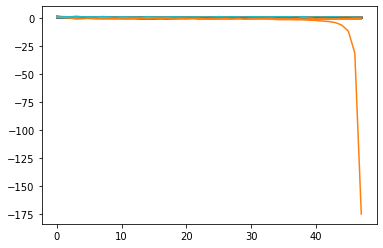

In [346]:
#画图看一下
plt.plot(temp_x, temp_y)
plt.show()

In [347]:
#k均值聚类
a = KMeans(Ucluster_number).fit(y[count-2: count-1, 0: number_user].T)  # 聚类
print(a)

KMeans(n_clusters=3)


In [348]:
#看前Ucluster_number个聚类结果
b = a.labels_ # 观察聚类结果
for i in range(0, Ucluster_number):
    print('%d:'% i, sum(b == i))
type(b)

0: 134
1: 25
2: 53


numpy.ndarray

In [349]:
index = [0]*Ucluster_number
sim_matrix = [0]*Ucluster_number

In [350]:
#这是干了个啥:好像是做什么相似化处理
for i in range(0, Ucluster_number):
    temp = np.where(b[:] == i)
    data = score_matrix[temp, :]
    index[i] = temp
    sim_matrix[i] = SimilitudItems(data[0].T, 'cosine')

In [351]:
# data = score_matrix[temp, :]
# data[0].shape

In [352]:
# 读测试集，预测开始
if mycase == 1:
    # u2 = uf
    u2 = pd.read_csv("features_Random.csv")
    # u2 = uf
    # print(u2)
    # u2 = pd.concat([uf,u2],axis=0,ignore_index=True)
    # u2 = u2.iloc[0:1000,:]
    # print(u2)
    # u2 = uf
    # u2=pd.concat([u2,uf],axis=0)
    # u2 = pd.read_csv("u1test.csv")
elif mycase == 2:
    u2 = pd.read_csv("u2test.csv")
elif mycase == 3:
    u2 = pd.read_csv("u3test.csv")
elif mycase == 4:
    u2 = pd.read_csv("u4test.csv")
elif mycase == 5:
    u2 = pd.read_csv("u5test.csv")

In [353]:
# u2 = u2[:6437]
pp = np.where(u2["item_id"] > max(u1["item_id"]))  # 出现在测试集中，但没有出现在训练集中的项目
print(u2.item_id.unique)
# print(pp)

<bound method Series.unique of 0      33
1      69
2      55
3      35
4      29
       ..
995    88
996    88
997    80
998    71
999     6
Name: item_id, Length: 1000, dtype: int64>


In [354]:
m = u2.shape[0]
Predict_score = np.zeros((m, 1))  # 预测分数矩阵，规模为20000 * 1

In [355]:
m


1000

In [356]:
#测试集评分矩阵
score_matrix2 = np.zeros([212,90])
for i in range(0, m):
    score_matrix2[int(u2["user_id"][i]-1)][int(u2["item_id"][i]-1)] = u1["score"][i] # 填评分矩阵
print(score_matrix2)


[[ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ... 63.669  0.    89.617]
 ...
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]]


In [357]:
i = 2
print(i, end=" ")
user = u2["user_id"][i]  # 获取测试集中第i个用户的id
item = u2["item_id"][i]  # 获取测试集中第i个电影的id
no2 = b[user-1]  # no2表示id为user的这个用户属于哪一个社区
user1 = np.where(index[no2][0] == user-1)
# 以下是计算基于用户的协同过滤
up_score_matrix = score_matrix[index[no2][0]]  # 获取同社区的用户评分矩阵

2 

In [358]:
up_score_matrix.shape
print(u2["score"])

0       276.255
1       217.024
2      1014.636
3       173.076
4       442.639
         ...   
995      14.969
996       7.484
997      12.972
998     308.032
999      39.920
Name: score, Length: 1000, dtype: float64


In [359]:
for i in range(0, 1000):
    if i % 1000 == 0:
        print(i/1000, 'k', end=" ")
    user = u2["user_id"][i]  # 获取测试集中第i个用户的id
    item = u2["item_id"][i]  # 获取测试集中第i个电影的id
    no2 = b[user-1]  # no2表示id为user的这个用户属于哪一个社区
    user1 = np.where(index[no2][0] == user-1)
    # 以下是计算基于用户的协同过滤
    up_score_matrix = score_matrix[index[no2][0]] # 获取同社区的用户评分矩阵
    BB1 = np.where(up_score_matrix[user1[0][0],:] != 0)  # 与user处于同社区的评分矩阵中第user1个用户已评分的电影id
    # 某一用户平均评分
    aver_score1 = np.mean(up_score_matrix[user1[0][0], BB1],1)  # 该用户对已评分项目的平均值
    BB = np.where(score_matrix[:, :] != 0)
    # 所有用户平均评分
    aver_score = np.mean(score_matrix[BB])

    P_u = np.where(up_score_matrix[:,item-1] != 0)
    # P_u = np.where(int(up_score_matrix[:,item-1]) != 0)  # P_u记录与user处于同社区，看过id=item电影的用户在该社区的索引
    if len(P_u) == 0:
        i = 0
        Predict_score[i] = round(aver_score1)
    else:
        P_u_sim = sim_matrix[no2][user1[0][0]][P_u[0]]  # 计算待评价用户与已评价用户的相似度
        s = pd.Series(P_u_sim).sort_values(ascending = False)[:]
        index1 = s.index.tolist()
        num1 = len(index1)
        if num1 >= neibor_num: # 如果index1记录的id比neibor_num还多，只要前neibor_num个
            neibor = [0 for i in range(neibor_num)]
            a_score = [0 for i in range(neibor_num)]
            for k in range(0, neibor_num):
                neibor[k] = P_u[0][index1[k]]
        else:
            neibor = [0 for i in range(num1)]
            a_score = [0 for i in range(num1)]
            for k in range(0, num1):
                neibor[k] = P_u[0][index1[k]]
        sum1 = 0
        sum2 = 0
        for j in range(0, len(neibor)):
            BB = np.where(up_score_matrix[neibor[j], :] != 0)
            a_score[j] = np.mean(up_score_matrix[neibor[j], BB], 1)
            sum1 += sim_matrix[no2][user1,neibor[j]] * (up_score_matrix[neibor[j],item-1] - a_score[j])
            sum2 += sim_matrix[no2][user1,neibor[j]]
        if sum2 == 0:   # 没有和带预测项目相似的项目
            Predict_score[i] = np.round(aver_score1) # 排除分母为零的情况
        else:
            Predict_score[i] = np.round(aver_score1 + sum1[0][0] / sum2[0][0])
    # if Predict_score[i] > 5:
    #     Predict_score[i] = 5
    # elif Predict_score[i] < 1:
    #     Predict_score[i] = 1
    if Predict_score[i] == 'NaN': # 如果数值为None
        Predict_score[i] = np.round(aver_score1) # round用于舍入到最接近的整数



# #136是测试集中不同rna的数量
# disease = np.ones([212,90])
# for i in range(0, 136):
#     num_non_disease = 0
#     RNA_id = u2["user_id"][i]
#     #统计没有评分的疾病
#     for i in range(0,90):
#         if score_matrix2[RNA_id][i] == 0:
#             disease[RNA_id][i] = score_matrix2[RNA_id][i]
#             num_non_disease=num_non_disease+1
#     # if i % 1000 == 0:
#     #     print(i/1000, 'k', end=" ")
#     user = u2["user_id"][i]  # 获取测试集中第i个用户的id
#     #对没有进行评分的疾病做预测
#     for j in range(0,num_non_disease):
#         # item = u2["item_id"][i]  # 获取测试集中第i个电影的id
#         item = disease[i][j]
#         no2 = b[user-1]  # no2表示id为user的这个用户属于哪一个社区
#         user1 = np.where(index[no2][0] == user-1)
#         # 以下是计算基于用户的协同过滤
#         up_score_matrix = score_matrix[index[no2][0]] # 获取同社区的用户评分矩阵
#         # BB = np.where(up_score_matrix[user1[0][0],:] != 0)  # 与user处于同社区的评分矩阵中第user1个用户已评分的电影id
#         # print(item)
#         # print(up_score_matrix[user1[0][0],:])
#         # print(up_score_matrix[:,int(item)-1])
#         BB = np.where(up_score_matrix[user1[0][0],:] != -1)
#         aver_score = np.mean(up_score_matrix[user1[0][0], BB],1)  # 该用户对已评分项目的平均值
#         # print("=================",np.where(up_score_matrix[:,item-1] != 0))
#         P_u = np.where(up_score_matrix[:,int(item)-1] != 0)
#         # print(int(up_score_matrix[:,item-1]))
#         # P_u = np.where(int(up_score_matrix[:,item-1]) != 0)  # P_u记录与user处于同社区，看过id=item电影的用户在该社区的索引
#         if len(P_u) == 0:
#             i = 0
#             Predict_score[i] = round(aver_score[0])
#         else:
#             P_u_sim = sim_matrix[no2][user1[0][0]][P_u[0]]  # 计算待评价用户与已评价用户的相似度
#             s = pd.Series(P_u_sim).sort_values(ascending = False)[:]
#             index1 = s.index.tolist()
#             num1 = len(index1)
#             if num1 >= neibor_num: # 如果index1记录的id比neibor_num还多，只要前neibor_num个
#                 neibor = [0 for i in range(neibor_num)]
#                 a_score = [0 for i in range(neibor_num)]
#                 for k in range(0, neibor_num):
#                     neibor[k] = P_u[0][index1[k]]
#             else:
#                 neibor = [0 for i in range(num1)]
#                 a_score = [0 for i in range(num1)]
#                 for k in range(0, num1):
#                     neibor[k] = P_u[0][index1[k]]
#             sum1 = 0
#             sum2 = 0
#             for j in range(0, len(neibor)):
#                 BB = np.where(up_score_matrix[neibor[j], :] != 0)
#                 a_score[j] = np.mean(up_score_matrix[neibor[j], BB], 1)
#                 sum1 += sim_matrix[no2][user1,neibor[j]] * (up_score_matrix[neibor[j],int(item)-1] - a_score[j])
#                 sum2 += sim_matrix[no2][user1,neibor[j]]
#             if sum2 == 0:   # 没有和带预测项目相似的项目
#                 Predict_score[i] = np.round(aver_score[0]) # 排除分母为零的情况
#             else:
#                 Predict_score[i] = np.round(aver_score[0] + sum1[0][0] / sum2[0][0])
#         if Predict_score[i] > 5:
#             Predict_score[i] = 5
#         elif Predict_score[i] < 1:
#             Predict_score[i] = 1
#         elif Predict_score[i] == None: # 如果数值为None
#             Predict_score[i] = np.round(aver_score) # round用于舍入到最接近的整数

0.0 k 

c:\users\33181\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [360]:
# Predict_score

In [361]:
ans1 = u2["score"][:].values.tolist()
ans2 = Predict_score.tolist()

In [362]:
Eval = [0 for i in range(len(ans1))]
for i in range(len(ans1)):
    Eval[i] = abs(ans1[i] - ans2[i][0])

In [363]:
MAE = sum(Eval) / m
MAE

477.6291769999998

In [364]:
RMSE = math.sqrt(np.dot(Eval, Eval) / m)
RMSE

1024.3997086915815

In [365]:
m1 = u2.shape[0]
n1 = u2.shape[1]

In [366]:
number_user1 = max(u2["user_id"])
number_movies1 = max(u2["item_id"])
score_matrix11 = np.zeros([number_user1, number_movies1])

In [367]:
u2 = u2.rename(columns={'time':'Pre_score'})

In [368]:
for i in range(0, m1):
    score_matrix11[u2["user_id"][i]-1][u2["item_id"][i]-1] = u2["score"][i]
    u2["Pre_score"][i] = Predict_score[i] # u2从20000*4矩阵变为20000*5矩阵，多了一列预测评分

c:\users\33181\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [369]:
from sklearn import metrics

BB2 = np.where(u2["score"] != 0)
aver_score2 = np.mean(u2["score"])
# print(u2["score"])
# print(u2["Pre_score"])
# u2["score"] >= aver_score2 = 1  # 大于等于0.5的设为1
# u2["score"] < aver_score2 = 0  # 小于0.5的设为0
for i in range(len(u2["score"])):
    if u2["score"][i]>=aver_score2:
        u2["score"][i]=1
    else:
        u2["score"][i]=0
# print(u2["score"])
for i in range(len(u2["Pre_score"])):
    if u2["Pre_score"][i]>=aver_score2:
        u2["Pre_score"][i]=1
    else:
        u2["Pre_score"][i]=0
# print(u2["Pre_score"])
roc_score = metrics.roc_auc_score(u2["score"], u2["Pre_score"])
ap_score = metrics.average_precision_score(u2["score"], u2["Pre_score"])
# u2["Pre_score"][u2["Pre_score"] >= np.round(aver_score)] = 1  # 大于等于0.5的设为1
# u2["Pre_score"][u2["Pre_score"] < np.round(aver_score)] = 0  # 小于0.5的设为0
accuracy = metrics.accuracy_score(u2["score"], u2["Pre_score"])
f1 = f1_score(u2["score"], u2["Pre_score"])  # 计算分数
print("========",roc_score,ap_score,accuracy,f1)


c:\users\33181\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\users\33181\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\33181\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

======== 0.8225773060056838 0.5260688887475352 0.864 0.6880733944954128
